In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df=pd.read_csv('EWLI_baseline_data_cleaned.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11260 entries, 0 to 11259
Columns: 154 entries, City to k_interest/k_participate/k05
dtypes: int64(35), object(119)
memory usage: 13.2+ MB


In [4]:
df.head()

,City,Enumerator,loc_herat,a_basics/a01,a_basics/a02,a_basics/a03,b_hh/b01a,b_hh/b01b,b02a,b02b,...,i_adaptive/i11,j_stereotypes/j01,j_stereotypes/j02,j_stereotypes/j03,j_stereotypes/j0,k_interest/k01,k_interest/k_participate/k02,k_interest/k_participate/k03,k_interest/k_participate/k04,k_interest/k_participate/k05
0,herat,samira,herat_01,male,married living with spouse,tajik,0,0,0,0,...,other,idp_host,other,other,stigma_pasht,yes,ben_women ben_men,ben_women ben_men,ben_women ben_men,ben_men
1,herat,samira,herat_01,female,married living with spouse,hazara,0,0,0,0,...,other,idp_host,other,other,stigma_pasht,yes,ben_women,not_interested,ben_women,ben_women
2,herat,samira,herat_01,female,married living with spouse,pashtun,0,0,0,0,...,other,idp_host,other,other,stigma_same,yes,ben_women ben_men,ben_women ben_men,ben_women ben_men,ben_women ben_men
3,herat,samira,herat_01,female,widow,tajik,0,0,0,0,...,other,idp_host,other,other,stigma_pasht,yes,ben_women ben_men,ben_women ben_men,ben_women ben_men,ben_women ben_men
4,herat,samira,herat_01,female,married living with spouse,tajik,0,0,0,1,...,other,idp_host,other,other,stigma_pasht,yes,ben_women ben_men,ben_women ben_men,ben_women ben_men,ben_women ben_men


In [5]:
# percentage of each ethnicity type, checking for imbalance
df['a_basics/a03'].value_counts(normalize=True) * 100

pashtun    51.971581
tajik      40.754885
hazara      4.165187
turkmen     1.429840
arab        0.559503
uzbeck      0.506217
other       0.426288
baloch      0.186501
Name: a_basics/a03, dtype: float64

##### Modelling

In [6]:
# drop rows with 'other' ethnicity 
rows_to_drop = df[df['a_basics/a03']=='other'].index
df.drop(rows_to_drop, inplace=True)

Preprocessing steps

In [7]:
y = df.pop('a_basics/a03')

In [8]:
# Create a boolean mask for categorical columns
categorical_mask = (df.dtypes == object)

# Get list of categorical column names
categorical_columns = df.columns[categorical_mask].tolist()

# Create a boolean mask for numerical columns
numerical_mask = (df.dtypes == 'int64')

# Get list of numerical column names
numerical_columns = df.columns[numerical_mask].tolist()

In [9]:
def get_dummy_columns(columns_list, df):
    dummy_columns = []
    for column in columns_list:
        for row in df[column]:
            if len(row.split())>1:
                dummy_columns.append(column)
                #print(row)
                break
            else:
                continue
    return dummy_columns

In [10]:
dummy_1 = get_dummy_columns(categorical_columns, df)

In [11]:
dummy_2 = [item for item in categorical_columns if item not in dummy_1]

In [12]:
# Function that converts given categorical columns into dummies.
def convert_col_dummies(columns, df):
    for col in columns:
        new = df[col].str.get_dummies(sep=' ').rename(lambda x: col + '_' + x, axis='columns')
        df = df.join(new)
    res = df.drop(columns, axis=1)
    return res

In [13]:
res_1 = convert_col_dummies(dummy_1, df[dummy_1])
res_2 = pd.get_dummies(df[dummy_2])
res_3 = df[numerical_columns]

In [14]:
df_ = pd.concat([res_1, res_2, res_3], axis = 1)

In [15]:
df_.head()

,a_basics/a02_divorced,a_basics/a02_engaged,a_basics/a02_living,a_basics/a02_married,a_basics/a02_not,a_basics/a02_spouse,a_basics/a02_widow,a_basics/a02_with,c_origin/c03_abband,c_origin/c03_abkamari,...,e_food/e_fcs/e06,e_food/e_fcs/e07,e_food/e_fcs/e08,e_food/e_fcs/e09,f_access/f_lit/f01a,f_access/f_lit/f01b,h_assets/h01a,i_adaptive/i01,i_adaptive/i01income_count,i_adaptive/i04
0,0,0,1,1,0,1,0,1,0,0,...,3,7,7,7,3,4,40,2,2,8000
1,0,0,1,1,0,1,0,1,0,0,...,4,6,7,7,3,1,30,1,1,3000
2,0,0,1,1,0,1,0,1,0,0,...,0,6,7,7,4,9,30,3,3,7000
3,0,0,0,0,0,0,1,0,0,0,...,3,4,7,7,0,1,20,1,1,4000
4,0,0,1,1,0,1,0,1,0,0,...,0,0,7,7,3,3,20,1,1,3000


Xgboost

In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_le = le.fit_transform(y)

In [17]:
set(y_le)

{0, 1, 2, 3, 4, 5, 6}

In [18]:
#r_dict = {}
#for col in ready_to_go.columns:
#    corr_mat = np.corrcoef(ready_to_go[col], y_le)
#    r = corr_mat[0,1]
#    r_dict[col]=r
#sorted([(value,key) for (key,value) in r_dict.items()])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df_, y_le, test_size = 0.3, random_state=42, stratify=y)

In [20]:
X_train.shape, y_train.shape

((7848, 946), (7848,))

In [21]:
#balance the data
from imblearn.over_sampling import SMOTE

# Define the resampling method
method = SMOTE('minority')

# Create the resampled feature set
X_resampled, y_resampled = method.fit_sample(X_train, y_train)

print(X_resampled.shape, y_resampled.shape)

(11929, 946) (11929,)


In [22]:
# X,y = X_resampled, y_resampled
# Perform grid search
# grid = GridSearchCV(estimator=xgb_pipeline, param_grid=param_grid,
#                        cv=5, n_jobs=2)
# grid.fit(X,y)
# Print the best parameters and best score
# print("Best parameters found: ", grid.best_params_)
# print("Best score found: ", grid.best_score_)


param_grid = {
                'xgb__learning_rate': np.arange(.05, 1, .05), 
                'xgb__max_depth': np.arange(2,10, 1), 
                'xgb__n_estimators': np.arange(50, 200, 50),
                'xgb__min_child_weight': np.arange(1,8,1)
             }

# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()), ('xgb', xgb.XGBClassifier(objective = 'multi:softprob'))]

# Create the pipeline: xgb_pipeline
xgb_pipeline = Pipeline(steps)

# Perform random search:
randomized = RandomizedSearchCV(estimator=xgb_pipeline, param_distributions=param_grid,
                                    n_iter=5, cv=4, verbose=1, n_jobs=2)
# Fit the estimator
randomized.fit(X_resampled, y_resampled)

# Print the best parameters and best score
print("Best parameters found: ", randomized.best_estimator_)
print("Best score found: ", randomized.best_score_)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed: 27.6min finished
C:\Users\wibot\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\wibot\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Best parameters found:  Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])
Best score found:  0.8832257523681784


In [30]:
# Take the best estimator
xgbbest = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, device='gpu', gamma=0,
                               learning_rate=0.45, max_delta_step=0,
                               max_depth=8, min_child_weight=3, missing=None,
                               n_estimators=50, n_jobs=1, nthread=None,
                               objective='multi:softprob', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1)

# Fit the estimator
xgbbest.fit(X_resampled, y_resampled)

# Get your performance metrics
predicted = xgbbest.predict(X_test.values)

In [31]:
le.classes_

array(['arab', 'baloch', 'hazara', 'pashtun', 'tajik', 'turkmen',
       'uzbeck'], dtype=object)

In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predicted))

from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, predicted))

C:\Users\wibot\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\wibot\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\wibot\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.00      0.00      0.00         6
           2       0.91      0.81      0.86       141
           3       0.89      0.84      0.86      1756
           4       0.77      0.87      0.82      1377
           5       0.27      0.06      0.10        48
           6       0.67      0.24      0.35        17

   micro avg       0.83      0.83      0.83      3364
   macro avg       0.50      0.40      0.43      3364
weighted avg       0.82      0.83      0.82      3364

[[   0    0    1    2   16    0    0]
 [   0    0    0    2    4    0    0]
 [   0    0  114    6   21    0    0]
 [   1    0    3 1478  273    1    0]
 [   0    0    7  164 1197    7    2]
 [   0    0    0    9   36    3    0]
 [   0    0    0    6    7    0    4]]


Wall time: 27.4 s


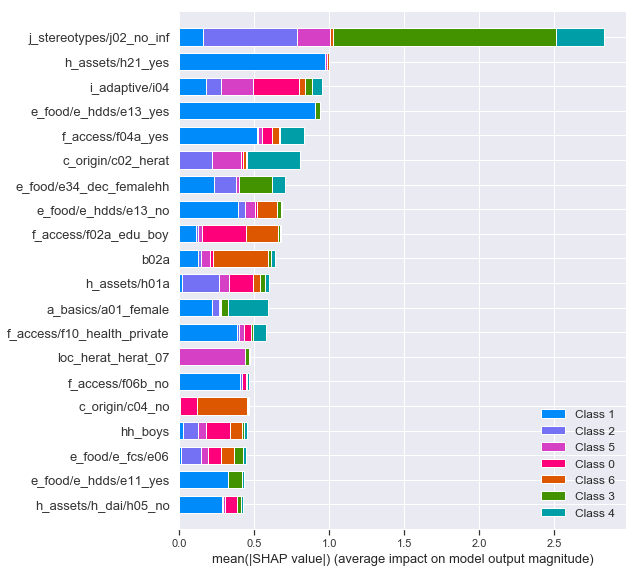

In [33]:
import shap
#explainerXGB = shap.TreeExplainer(xgbbest)
#shap_values_XGB_test = explainerXGB.shap_values(X_test)
#shap_values_XGB_train = explainerXGB.shap_values(X_train)
#shap.initjs() 
#shap.force_plot(explainerXGB.expected_value[0], shap_values_XGB_test[0])
%time shap_values = shap.TreeExplainer(xgbbest).shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [68]:
#shap.summary_plot(shap_values[0], X_test)

In [34]:
# Feature importance
fi = pd.DataFrame(list(zip(X_train.columns, xgbbest.feature_importances_)), columns = ['feature', 'importance'])
fi.sort_values('importance',ascending=False, inplace=True)

In [38]:
rename = {'i_adaptive/i04': 'Average monthly income', 'hh_total': 'Total number of people/household', 'h_assets/h01a': 'Number of households living in the arrangement', 'e_food/e_fcs/e03': 'Vegetable consumption during last week (how many days)', 'e_food/e_fcs/e05':'Beef, goat, poultry, eggs, fish, sheep consumption during last week (how many days at least one of the products)', 'e_food/e_fcs/e06':'Dairy products consumption during last week (in days)', 'hh_female': 'Total number of females per household', 'f_access/f_lit/f01a': 'Number of females over the age of 12 who can read/write(per household)', 'hh_male': 'Total number of males per household', 'e_food/e_fcs/e02': 'Beans/peas/nuts consumption during last week (how many days at least one of the products)', 'hh_girls': 'Total number of girls per household', 'f_access/f_lit/f01b': 'Number of males over the age of 12 who can read/write(per household)'}
for k,v in rename.items():
    fi.loc[fi['feature']==k,'feature'] = v

In [40]:
#plt.figure()
#fi[fi['importance']>0.01].plot(kind='barh', x='feature', y='importance', legend=False, figsize=(8, 8))
#plt.gcf().savefig('features_importance.png')

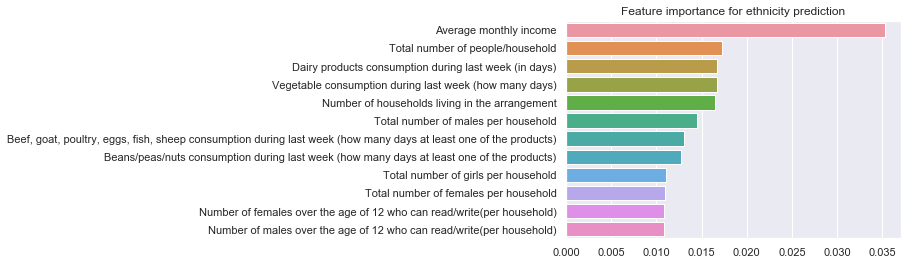

In [39]:
import seaborn as sns
sns.set()
ax = sns.barplot(x='importance', y='feature', data=fi[fi['importance']>0.01])
ax.set(xlabel='', ylabel='')
plt.title('Feature importance for ethnicity prediction')
plt.show()